# Модель для предсказывания ухода клиента

**Описание:**

Оператор связи «НиЕдиногоРазрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. На основе этих данных будет создан датасет для обучения модели.

Телеком предоставляет два вида услуг 
- телефонная связь, с возможность подключения несколька линий
- интернет через телефонную линнию или оптоволокно. 

Так же есть дополнительные услуги 
- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

# 1 План 

## 1.1 Выгрузка и осмотр данных

In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install phik -q
!pip install scikit-learn==1.1.3 -q

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import phik
from phik import resources, report

#from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split)
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 100423

In [3]:
#C:\Users\niklu\Desktop\jupyter\data
try:
    data_contract = pd.read_csv('C:\\Users\\niklu\\Desktop\\jupyter\\data\\finals_data\\contract_new.csv', index_col = 'customerID')
    data_person = pd.read_csv("C:\\Users\\niklu\\Desktop\\jupyter\\data\\finals_data\\personal_new.csv", index_col = 'customerID')
    data_phone = pd.read_csv("C:\\Users\\niklu\\Desktop\\jupyter\\data\\finals_data\\phone_new.csv", index_col = 'customerID')
    data_inet = pd.read_csv("C:\\Users\\niklu\\Desktop\\jupyter\\data\\finals_data\\internet_new.csv", index_col = 'customerID')

    display ('КОНТРАКТЫ', data_contract.shape ,data_contract.head())
    display ('ПЕРСОНАЛЬНЫЕ', data_person.shape, data_person.head())
    display ('ТЕЛЕФОНИЯ', data_phone.shape, data_phone.head())
    display ('ИНТЕРНЕТ', data_inet.shape, data_inet.head())
    
except:
    data_contract = pd.read_csv('/datasets/contract_new.csv', index_col = 'customerID')
    data_person = pd.read_csv("/datasets/personal_new.csv", index_col = 'customerID')
    data_phone = pd.read_csv("/datasets/phone_new.csv", index_col = 'customerID')
    data_inet = pd.read_csv("/datasets/internet_new.csv", index_col = 'customerID')

    display ('КОНТРАКТЫ', data_contract.shape ,data_contract.head())
    display ('ПЕРСОНАЛЬНЫЕ', data_person.shape, data_person.head())
    display ('ТЕЛЕФОНИЯ', data_phone.shape, data_phone.head())
    display ('ИНТЕРНЕТ', data_inet.shape, data_inet.head())

'КОНТРАКТЫ'

(7043, 7)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


'ПЕРСОНАЛЬНЫЕ'

(7043, 4)

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


'ТЕЛЕФОНИЯ'

(6361, 1)

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


'ИНТЕРНЕТ'

(5517, 7)

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


## 1.2 Объеденение таблиц

Для анализа и последущего обучения модели все данные необходио соеденить в одну таблицу.

В первую очередь объеденяю контракты и персональные данные, предпологаю что пропусков там быть не должно

In [4]:
data_full = data_contract.join(data_person)
print (data_full.isnull().sum(), data_full.shape)
data_full

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64 (7043, 11)


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents
customerID,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,Male,0,Yes,Yes
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,Female,0,Yes,Yes
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,Female,0,Yes,Yes


Данные объеденились успешно, без пропусков, по индексу которым выступает индефикатор пользователя. Теперь более сложное объеденение, где должны появится пропуски. 

In [5]:
data_full = data_full.join(data_inet)
data_full = data_full.join(data_phone)
print (data_full.isnull().sum(), data_full.shape) 

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64 (7043, 19)


In [6]:
data_full = data_full.fillna('No')  
print (data_full.isnull().sum(), data_full.shape)

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64 (7043, 19)


Образававшиеся пропуски были заполнены No, так все они отвечают за предоставляемые услуги.

## 1.3 Список уточняющих вопросов

1) Если индефикатора клиента нет в таблицах phone_new.csv и internet_new.csv означает ли это, что клиенту не предоставялется данная услуга?

2) В какую дату данные были выгруженны из системы?

### Ответы
    
1) да, все верно

2) 1 февраля 2020

## 1.4 Примерный план

- Анализ данных

Данные будут исследованны на аномалии и ошибки
- Подготовка признаков  

Из данных будут выделенны признаки, которые будут подготовленны для корректной работы модели и удалены признаки, которые мешают работе модели
- Исследование моделей
    - Данные будут разделенны на выборки 
    - Будут обучены несколько моделей и полученные результаты на валидационой выборки 
    - Сравнение результатов моделей
- Тестирование модели 

Лучшая модель будет проверенна на тестовой выборке 
- Подготовка отчета 

## 1.5 Цель 

Цель данной работы получить корректно работающую модель. 

В качестве метрики качества выбрана **AUC-ROC** и ее качество должно быть выше 0.85, дополнительная метрика **точность**.

# 2 Предобработка и исследование признаков 

In [7]:
data_full.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [8]:
#data_full['BeginDate'] = datetime.strptime(data_full['BeginDate'], '%Y-%m-%d') 
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

## 2.1 Обработка дубликатов 

Для начала проверю данные на дубликаты, не записан ли один клиент дважды 

In [9]:
data_full.duplicated().sum()

4

Обнаружил всего 4 дубликата из более чем 7 тысяч образцов, просто их удалю

In [10]:
data_full = data_full.drop_duplicates()
#print()

## 2.2 Создание нового признака 

Чем больше инфомации будет переданно модели, тем потециально качественее будет результат, поэтому из имеющихся данных создам новый признак duration (как долго человек является или был клиентом банка)

In [11]:
#Переменная с датой выгрузки данных 
c_date = datetime.strptime('2020-02-01', '%Y-%m-%d')
c_date

datetime.datetime(2020, 2, 1, 0, 0)

In [12]:
def create_duration(data_full):
    if data_full['EndDate'] == 'No':
        return c_date - datetime.strptime(data_full['BeginDate'], '%Y-%m-%d')
    else:
        return datetime.strptime(data_full['EndDate'], '%Y-%m-%d') - datetime.strptime(data_full['BeginDate'], '%Y-%m-%d')

In [13]:
data_full['duration'] = data_full.apply(create_duration, axis=1)

data_full.head(3)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,31 days
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,1036 days
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,123 days


## 2.3 Изменения типа данных

Так же нужно изменить тип данных численных столбца, чтобы далее они корректно обработались.

In [14]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   BeginDate         7039 non-null   object         
 1   EndDate           7039 non-null   object         
 2   Type              7039 non-null   object         
 3   PaperlessBilling  7039 non-null   object         
 4   PaymentMethod     7039 non-null   object         
 5   MonthlyCharges    7039 non-null   float64        
 6   TotalCharges      7039 non-null   object         
 7   gender            7039 non-null   object         
 8   SeniorCitizen     7039 non-null   int64          
 9   Partner           7039 non-null   object         
 10  Dependents        7039 non-null   object         
 11  InternetService   7039 non-null   object         
 12  OnlineSecurity    7039 non-null   object         
 13  OnlineBackup      7039 non-null   object         
 14

Необходимо преобразовать duration в int и TotalCharges в float. В TotalCharges обнаружена аномалия ввиде пустого значения их 11 и заменю на ноль 

In [15]:
data_full[data_full['TotalCharges']==' '].count()

BeginDate           11
EndDate             11
Type                11
PaperlessBilling    11
PaymentMethod       11
MonthlyCharges      11
TotalCharges        11
gender              11
SeniorCitizen       11
Partner             11
Dependents          11
InternetService     11
OnlineSecurity      11
OnlineBackup        11
DeviceProtection    11
TechSupport         11
StreamingTV         11
StreamingMovies     11
MultipleLines       11
duration            11
dtype: int64

In [16]:
data_full['TotalCharges'].loc[data_full['TotalCharges'] == ' '] = '0'

In [17]:
data_full['duration'] = data_full['duration'].dt.days #дата в int
data_full['TotalCharges'] = data_full['TotalCharges'].astype('float64')

In [18]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7039 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7039 non-null   object 
 1   EndDate           7039 non-null   object 
 2   Type              7039 non-null   object 
 3   PaperlessBilling  7039 non-null   object 
 4   PaymentMethod     7039 non-null   object 
 5   MonthlyCharges    7039 non-null   float64
 6   TotalCharges      7039 non-null   float64
 7   gender            7039 non-null   object 
 8   SeniorCitizen     7039 non-null   int64  
 9   Partner           7039 non-null   object 
 10  Dependents        7039 non-null   object 
 11  InternetService   7039 non-null   object 
 12  OnlineSecurity    7039 non-null   object 
 13  OnlineBackup      7039 non-null   object 
 14  DeviceProtection  7039 non-null   object 
 15  TechSupport       7039 non-null   object 
 16  StreamingTV       7039 non-null 

## 2.4 Создание таргета

Теперь необходимо создать сам таргет. Необходимо обнаружить клиентов которые ушли из компании, поэтому в столбце таргет 1 будет у клиетов у которых в EndDate не No.

In [19]:
data_full['target'] = np.where(data_full['EndDate'] !='No', 1, 0)
display (data_full.head(3))
display (data_full.loc[data_full['target'] == 1].head(3))

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,target
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,...,DSL,No,Yes,No,No,No,No,No,31,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,...,DSL,Yes,No,Yes,No,No,No,No,1036,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,123,0


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,target
customerID,,,,,,,,,,,,,,,,,,,,,
6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,882,1
3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.50,Female,0,Yes,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,670,1
6865-JZNKO,2017-08-01,2018-09-01,Month-to-month,Yes,Bank transfer (automatic),55.30,726.09,Female,0,No,...,DSL,Yes,Yes,No,No,No,No,No,396,1


## 2.5 Анализ корреляций

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'duration', 'target']


<AxesSubplot:>

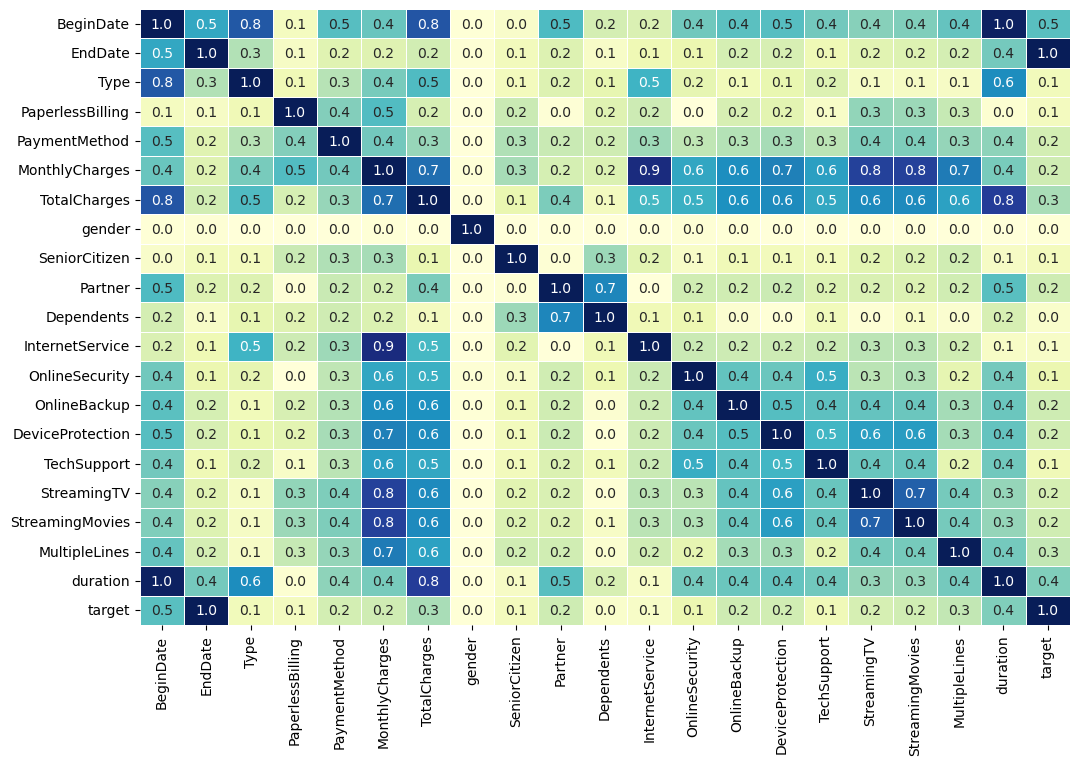

In [20]:
cor = data_full.phik_matrix()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cor, 
            linewidths=.5,
            annot=True, 
            cmap='YlGnBu',
            cbar=False,
            fmt=".1f")
            #height= 12)
            #aspect= .6)

Большинство значимых корреляций очевидны имеют очень понятную структуру
- Интерент одна из самих дорогих услуг поэтому и ежемесячный платеж больше
- Признык и дата EndDate, по пянтной причине полностью совпадают
- Большинство интернет услуг связаны, скорее всего их берут в комплексе

Интересные инсайды из анализа корреляций признаков:
- От пола ничего не зависит 
- Наличие парнетра связано с длительностью пользования услугами компании
- Так же длительность связана с таргетом, так что можно сказать, что новый признак был найден удачно

## 2.6 Потрет пользователя 

Перед началом использования модели необходимо понять, на чем будут основаваться её выводы. Для составление этого понимания необходимо определить пользователя который до сих пор являтся клиентом и который уже ушел от компании.

In [21]:
data_pos = data_full.loc[data_full['target'] == 0]
data_neg = data_full.loc[data_full['target'] == 1]
print (data_pos.shape, data_neg.shape)

(5938, 21) (1101, 21)


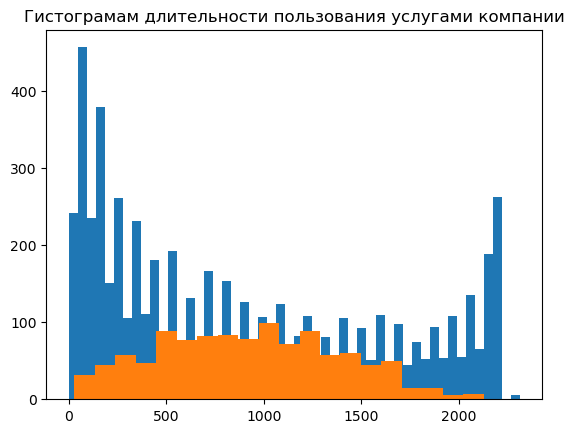

In [22]:
plt.hist(data_pos['duration'], bins=50)
plt.hist(data_neg['duration'], bins=20)

plt.title('Гистограмам длительности пользования услугами компании', fontdict={'size':12})

plt.show()

Из-за разности объема выборок (ушедших клиентов в 5 раз меньше) точного наложения не вышло, но в качестве предварительного вывода можно сказать, что активнее клиенты уходят после 1.5-5 лет пользования нашим телекомом.

In [23]:
display (data_neg.head(2))
print (data_neg.columns)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration,target
customerID,,,,,,,,,,,,,,,,,,,,,
6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,...,DSL,Yes,Yes,No,No,No,No,No,882,1
3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.25,2491.50,Female,0,Yes,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,670,1


Index(['BeginDate', 'EndDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'duration', 'target'],
      dtype='object')


In [24]:
uslugi = ['gender',
          'PaperlessBilling', 'SeniorCitizen', 'Partner', 
          'Dependents', 'OnlineSecurity', 'OnlineBackup', 
          'DeviceProtection', 'TechSupport', 'StreamingTV', 
          'StreamingMovies', 'MultipleLines']
#'gender', 'InternetService',

In [25]:
df_neg = data_neg[uslugi]
df_neg = df_neg.replace(['No', 'Yes'],[0, 1])
df_neg = df_neg.replace(['Male', 'Female'], [0,1])

df_pos = data_neg[uslugi]
df_pos = df_pos.replace(['No', 'Yes'],[0, 1])
df_pos = df_pos.replace(['Male', 'Female'], [0,1])

df_neg = df_neg.mean()
df_pos = df_pos.mean()

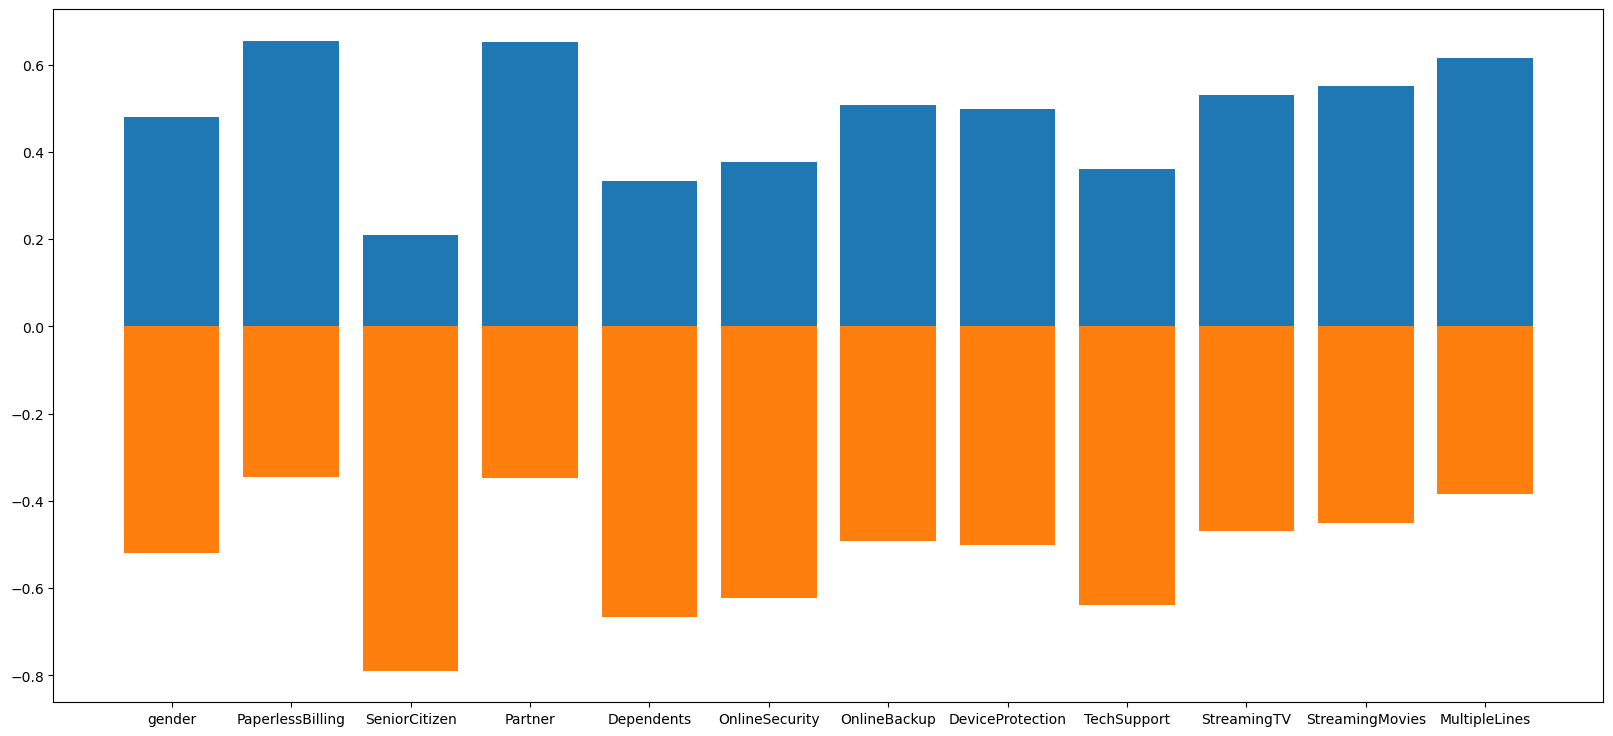

In [26]:
fig, ax = plt.subplots(figsize=(20,9))
plt.bar(uslugi, df_neg.values, width = .8)
plt.bar(uslugi, df_pos.values-1, width = .8)

plt.show()

Из полученых графика можно составить примерный портер уходяжего пользователя:
- Это НЕ пенсионер
- Человек уже более года пользуется услугами телекома
- Скорее всего у но есть партнер 
- Он менее активно пользуется дополнительными услугами телекома

Выводы:

- Можно предположить, что если пользователь будет определен моделью как уходящий, то стоит  предложить промокды или льготные условия на дополнительные сервисы. Так как уходя от нас он будет не просто менять опреатора связи или провайдера, но и терять широту услуг.

- Одной из самых весемых, важных услуг, можно назвать техническую поддержку.

- Так же стоит сделать факт выставления счёта на электронную почту для всех клиентов.

- Так же интерсно, что у уходящий пользователей чаще есть партнер. Веортяно уход связан с желанием обслуживаться в той же кампании, что и партнер. Можно добавить выгодные семейные тарифы.

# 3 Подготовка данных для модели 

## 3.1 Разделение на выборки 

Новый признак готов, таргет есть, пропусков нет. Теперь можно удалить лишнее, разделить на выборки и подготовить данные для обрабоки моделью.

In [27]:
data_full = data_full.drop(['BeginDate', 'EndDate'], axis=1)

In [28]:
features = data_full.drop(['target'], axis=1)
target = data_full['target']

x_train, x_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.25,
                                                    random_state=RANDOM_STATE,
                                                    stratify=target)

In [29]:
#Проверка коректности разделения на выборки 
print (x_train.shape, x_test.shape)
print (y_train.shape, y_test.shape)
display (x_train.head(5))
print (x_train.info())

(5279, 18) (1760, 18)
(5279,) (1760,)


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,duration
customerID,,,,,,,,,,,,,,,,,,
4959-JOSRX,Month-to-month,Yes,Credit card (automatic),44.60,267.60,Female,0,Yes,No,DSL,No,No,No,No,No,No,No,184
4686-GEFRM,Two year,Yes,Bank transfer (automatic),98.70,5808.49,Male,0,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,Yes,1675
3154-CFSZG,Month-to-month,No,Electronic check,90.05,4232.35,Male,0,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,Yes,No,1432
1867-TJHTS,Month-to-month,Yes,Bank transfer (automatic),79.80,2876.79,Female,0,No,No,Fiber optic,Yes,No,No,No,No,No,Yes,1065
7811-JIVPF,Month-to-month,No,Credit card (automatic),49.70,1165.96,Female,0,No,No,DSL,No,No,Yes,No,No,No,No,702


<class 'pandas.core.frame.DataFrame'>
Index: 5279 entries, 4959-JOSRX to 6419-ZTTLE
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5279 non-null   object 
 1   PaperlessBilling  5279 non-null   object 
 2   PaymentMethod     5279 non-null   object 
 3   MonthlyCharges    5279 non-null   float64
 4   TotalCharges      5279 non-null   float64
 5   gender            5279 non-null   object 
 6   SeniorCitizen     5279 non-null   int64  
 7   Partner           5279 non-null   object 
 8   Dependents        5279 non-null   object 
 9   InternetService   5279 non-null   object 
 10  OnlineSecurity    5279 non-null   object 
 11  OnlineBackup      5279 non-null   object 
 12  DeviceProtection  5279 non-null   object 
 13  TechSupport       5279 non-null   object 
 14  StreamingTV       5279 non-null   object 
 15  StreamingMovies   5279 non-null   object 
 16  MultipleLines     5279 non-null 

с выборками все впроядке теперь можно кодировать признаки 

## 3.2 Кодировка OHE

Кодировка требуется только для категироальных признаков, то есть не численых, поэтому сначала достану названия столбцов котоые буду кодиовать.

In [30]:
ohe_columns = x_train.select_dtypes(include='object').columns.to_list()

print (ohe_columns)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [31]:
x_train_coded = x_train.copy()
x_test_coded = x_test.copy()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(x_train_coded[ohe_columns])

x_train_coded[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(x_train_coded[ohe_columns])

x_test_coded[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(x_test_coded[ohe_columns])

x_train_coded = x_train_coded.drop(ohe_columns, axis=1)
x_test_coded = x_test_coded.drop(ohe_columns, axis=1)

display (x_train_coded.head(), x_train_coded.shape)

,MonthlyCharges,TotalCharges,SeniorCitizen,duration,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
4959-JOSRX,44.60,267.60,0,184,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4686-GEFRM,98.70,5808.49,0,1675,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0
3154-CFSZG,90.05,4232.35,0,1432,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1867-TJHTS,79.80,2876.79,0,1065,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
7811-JIVPF,49.70,1165.96,0,702,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


(5279, 22)

Данные обработаны, что бы модель смогла их прочесть, теперь можно обучить сами модели

# 4 Выбор модели

В данном разделе будет протестированно три модели и гиперпараметры к ним 
- CatBoost
- RandomForest
- LightGBM

Лучшая модель будет проверяна на тестовой выборке 

## 4.1CatBoost

In [32]:
model_ct = CatBoostClassifier(random_state=RANDOM_STATE)
params_ct = {'learning_rate': [0.03, 0.1],
              'depth': [4, 6, 10],
              'l2_leaf_reg': [1, 5, 9],
             }

In [33]:
ct_RandomGrid = RandomizedSearchCV(estimator = model_ct, 
                                   param_distributions = params_ct, 
                                   cv = 10, 
                                   verbose=2, 
                                   n_jobs = 4,
                                   scoring='roc_auc')

In [34]:
ct_RandomGrid.fit(x_train_coded, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
0:	learn: 0.6276858	total: 148ms	remaining: 2m 27s
1:	learn: 0.5624619	total: 150ms	remaining: 1m 14s
2:	learn: 0.5152760	total: 152ms	remaining: 50.7s
3:	learn: 0.4857958	total: 155ms	remaining: 38.5s
4:	learn: 0.4548092	total: 157ms	remaining: 31.2s
5:	learn: 0.4336410	total: 159ms	remaining: 26.3s
6:	learn: 0.4186904	total: 161ms	remaining: 22.8s
7:	learn: 0.4052645	total: 163ms	remaining: 20.2s
8:	learn: 0.3942017	total: 165ms	remaining: 18.2s
9:	learn: 0.3839267	total: 167ms	remaining: 16.6s
10:	learn: 0.3758499	total: 170ms	remaining: 15.3s
11:	learn: 0.3677803	total: 172ms	remaining: 14.2s
12:	learn: 0.3633450	total: 174ms	remaining: 13.2s
13:	learn: 0.3585240	total: 176ms	remaining: 12.4s
14:	learn: 0.3547908	total: 178ms	remaining: 11.7s
15:	learn: 0.3498658	total: 181ms	remaining: 11.1s
16:	learn: 0.3476555	total: 183ms	remaining: 10.6s
17:	learn: 0.3444890	total: 185ms	remaining: 10.1s
18:	learn: 0.3423417	total:

RandomizedSearchCV(cv=10,
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001AED0279F10>,
                   n_jobs=4,
                   param_distributions={'depth': [4, 6, 10],
                                        'l2_leaf_reg': [1, 5, 9],
                                        'learning_rate': [0.03, 0.1]},
                   scoring='roc_auc', verbose=2)

In [35]:
print (ct_RandomGrid.best_params_)
print (f'Roc-Auc : {ct_RandomGrid.best_score_:.3f}') #score(x_train_coded,y_train):.3f}'

{'learning_rate': 0.1, 'l2_leaf_reg': 1, 'depth': 4}
Roc-Auc : 0.921


## 4.2 RandomForest

In [36]:
model_rf = RandomForestClassifier(random_state=RANDOM_STATE)
params_rf = {'n_estimators': range(1, 101, 10),
               'max_depth': range(1,20, 2),
               'bootstrap': [True, False]}

In [37]:
rf_RandomGrid = RandomizedSearchCV(estimator = model_rf, 
                                   param_distributions = params_rf, 
                                   cv = 10, 
                                   verbose=2, 
                                   n_jobs = 4,
                                   scoring='roc_auc')

In [38]:
rf_RandomGrid.fit(x_train_coded, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=RandomForestClassifier(random_state=100423),
                   n_jobs=4,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': range(1, 20, 2),
                                        'n_estimators': range(1, 101, 10)},
                   scoring='roc_auc', verbose=2)

In [39]:
print (rf_RandomGrid.best_params_)
print (f' Roc-Auc: {rf_RandomGrid.best_score_:.3f}')

{'n_estimators': 61, 'max_depth': 9, 'bootstrap': False}
 Roc-Auc: 0.825


## 4.3 LightGBM

In [40]:
model_lg = LGBMClassifier(random_state=RANDOM_STATE)
param_lg = {
              'max_depth': [5, 20],
              'learning_rate': [0.01, 0.05, 0.1],
              'n_estimators': [100, 300],
              'reg_alpha': [0.1, 1],
              'reg_lambda': [0.5, 1]
}

In [41]:
lg_RandomGrid = RandomizedSearchCV(estimator = model_lg, 
                                   param_distributions = param_lg, 
                                   cv = 10, 
                                   verbose=2, 
                                   n_jobs = 4,
                                   scoring='roc_auc')

In [42]:
lg_RandomGrid.fit(x_train_coded, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=100423),
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 20],
                                        'n_estimators': [100, 300],
                                        'reg_alpha': [0.1, 1],
                                        'reg_lambda': [0.5, 1]},
                   scoring='roc_auc', verbose=2)

In [43]:
print (lg_RandomGrid.best_params_)
print (f'Roc-Auc : {lg_RandomGrid.best_score_:.3f}')

{'reg_lambda': 1, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 20, 'learning_rate': 0.1}
Roc-Auc : 0.889


Метрика Roc-Auc показала лучший результат на модели LightGBM

## 4.4 Проврека лучшей модели на тесте

Лучшей моделью оказался CatBoost, с лучшими гиперпараметрами проведем тестирование 

In [44]:
predict_proba = ct_RandomGrid.best_estimator_.predict_proba(x_test_coded)[:,1]
predict_proba

array([0.15123199, 0.02457066, 0.95360584, ..., 0.92858653, 0.00181908,
       0.04328144])

In [45]:
print (f' ROC-AUC лучшей модели на тесте: {roc_auc_score(y_test, predict_proba):.3f}')

 ROC-AUC лучшей модели на тесте: 0.941


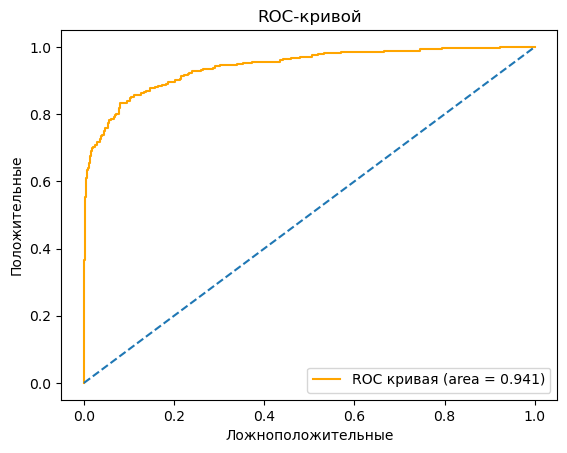

In [46]:
fpr, tpr, treshold = roc_curve(y_test, predict_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 
         color='orange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 
         linestyle='--')

plt.xlabel('Ложноположительные')
plt.ylabel('Положительные')
plt.title('ROC-кривой')
plt.legend(loc="lower right")

plt.show()

## 4.5 Анализ значимости признаков 

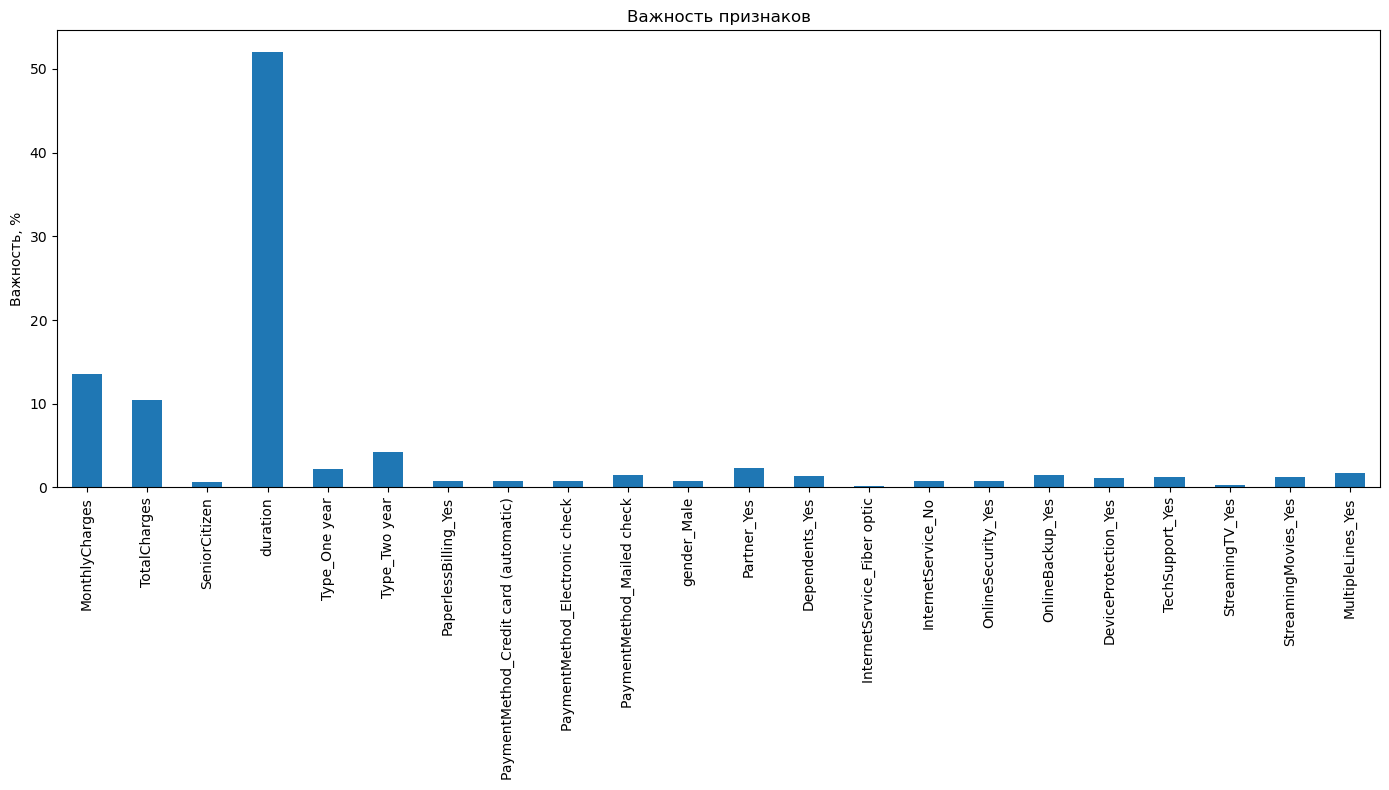

In [47]:
cat_iris_imp = pd.Series(ct_RandomGrid.best_estimator_.get_feature_importance(),
                         x_test_coded.columns)
fig, ax = plt.subplots(figsize=(14,8))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

# Отчет

## Цель работы

Создать, обучить и проверить на тестовой выборке модель с удовлетворябщем значение метрик (ROC-AUC => 0.85)

## **Этапы работы**

### Выгрузка данных
***
- **Загрузка данных в переменые**

Данные содержаться в четырёх файлах, их сохранили в четыре перменные, осмотрели и проверили форму.
- **Объеденение данных в единую таблицу**

Данные контрактов и лчиные данные полностьь совпадают по длине и проблемой с объеденением нет, а вот набор услуг телефонии и интернета разлиаются в данных появлись пропуски. Они были заполнены No, так как если человек не пользуется услугой он просто не попал в таблицы услуг


### Исследование и анализ данных
***
- **Поверка на дубликаты и пропуски**

В данных было обнаружено всего 4 дубликата она были удалены. Так же были обнаружены пропуски в столбце TotalCharges(Сумма всех зачислений), они были заполнены нулем.

- **Создание нового признака**

Для модели всегда полезно создать новый признак. Так как у нас есть информация о дате начала предостовления услуг, то есть возможность рассчитать количесво дней пользованиея услугами компании duration. Рассчет двух типов если есть дата окончания контраката то разница окончания действия контраката с датой начала действия, если клиент не ушел из компании, о разница между началом действия контракта с датой выгрузки данных (1 февраля 2022)

- **Создание таргета**

В нашим случае решается задача класификации ушел клиент или нет для модели это 1 или 0. Столбец таргета был создан по принципу есть ли дата окончания контракта, если есть, то 1, если нет, то 0.

- **Анализ корреляций** 

Анализ корреляций необходим для понимания взаимосвязи между данными. (Матрицу корреляиций см. Ячейка 20) 
Инсайды из анализа марицы:

   + Большинство значимых корреляций очевидны имеют очень понятную структуру
        - Интерент одна из самих дорогих услуг поэтому и ежемесячный платеж больше
        - Признык и дата EndDate, по пянтной причине полностью совпадают
        - Большинство интернет услуг связаны, скорее всего их берут в комплексе

   + Интересные инсайды из анализа корреляций признаков:
        - От пола ничего не зависит 
        - Наличие парнетра связано с длительностью пользования услугами компании
        - Так же длительность связана с таргетом, так что можно сказать, что новый признак был найден удачно
        
- **Соствление портрета уходящего пользователя**

Таблица была разделена на две части по таргету и проведен анализ разницы между ушедшими клиентами и действующими.
Инсайды которые удалось получить:

   + Это НЕ пинсионер
   + Человек уже более года пользуется услугами телекома
   + Скорее всего к но есть партнер 
   + Он менее активно пользуеься дополнительными услугами телекома

Гипотезы на основе инсайдов:

   + Можно предположить, что если пользователь будет определен моделью как уходящий, то стоит  предложить промокды или льготные условия на дополнительные сервисы. Так как уходя от нас он будет не просто менять опреатора связи или провайдера, но и терять широту услуг.
   + Одной из самых весемых, важных услуг, можно назвать техническую поддержку.
   + Так же стоит сделать факт выставления счёта на электронную почту для всех клиентов.
   + Так же интерсно, что у уходящий пользователей чаще есть партнер. Веортяно уход связан с желанием обслуживаться в той же кампании, что и партнер. Можно добавить выгодные семейные тарифы.

### Подготовка данных
***
- **Удалены лишние признаки**

- **ОНЕ**

Для того чтобы модель смогла обработать данные их перевести в числовой вид. Для этого я воспользовался OneHotEncoder. В наших данных в основном бинарные категориальные признаки, они перешли из вида Yes/No в 1/0. 

- **Разделение данных на выборки**

Весь датасет был разделен на две части в отношении 1/3. Это необходимо для тестирования модели, так как во время обучения я проверял ее на данных с которыми модель уже знакома. Поэтому четверть выборки выделяется на тестирование.


###  Проверка моделей 
***
Для обучения и проверке на кроссвалидации были взяты три модели классификаци RandomForest, LightGBM и CatBoost.
Результаты и лучшие гиперпараметры:

|               | CatBoost         | RandomForest   | LightGBM         |
|:--------------|:-----------------|:---------------|:-----------------|
|Лучшие         |learning_rate=0.1 | n_estimators=91| reg_lambda=1     |
|Гиперпараметры | l2_leaf_reg=5    | bootstrap=False| reg_alpha=0.1    |
|               | depth=4          | max_depth=9    | n_estimators=300 |
|               |                  |                | max_depth=20     |
|               |                  |                | learning_rate=0.1|
|Roc-Auc        |**0.916**         |**0.825**       |**0.889**         |

Как видно из таблицы лучше всего показал себя CatBoost.

### Тестировнание
***
Лучшая модель определенна и далее проверяна на тесовой выборке.

**Вывод метрики:**

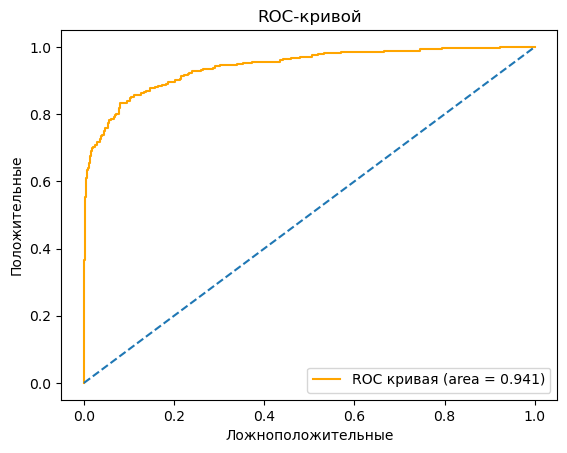

In [48]:
fpr, tpr, treshold = roc_curve(y_test, predict_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 
         color='orange',
         label='ROC кривая (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 
         linestyle='--')

plt.xlabel('Ложноположительные')
plt.ylabel('Положительные')
plt.title('ROC-кривой')
plt.legend(loc="lower right")

plt.show()

**Вывод важности признаков:**

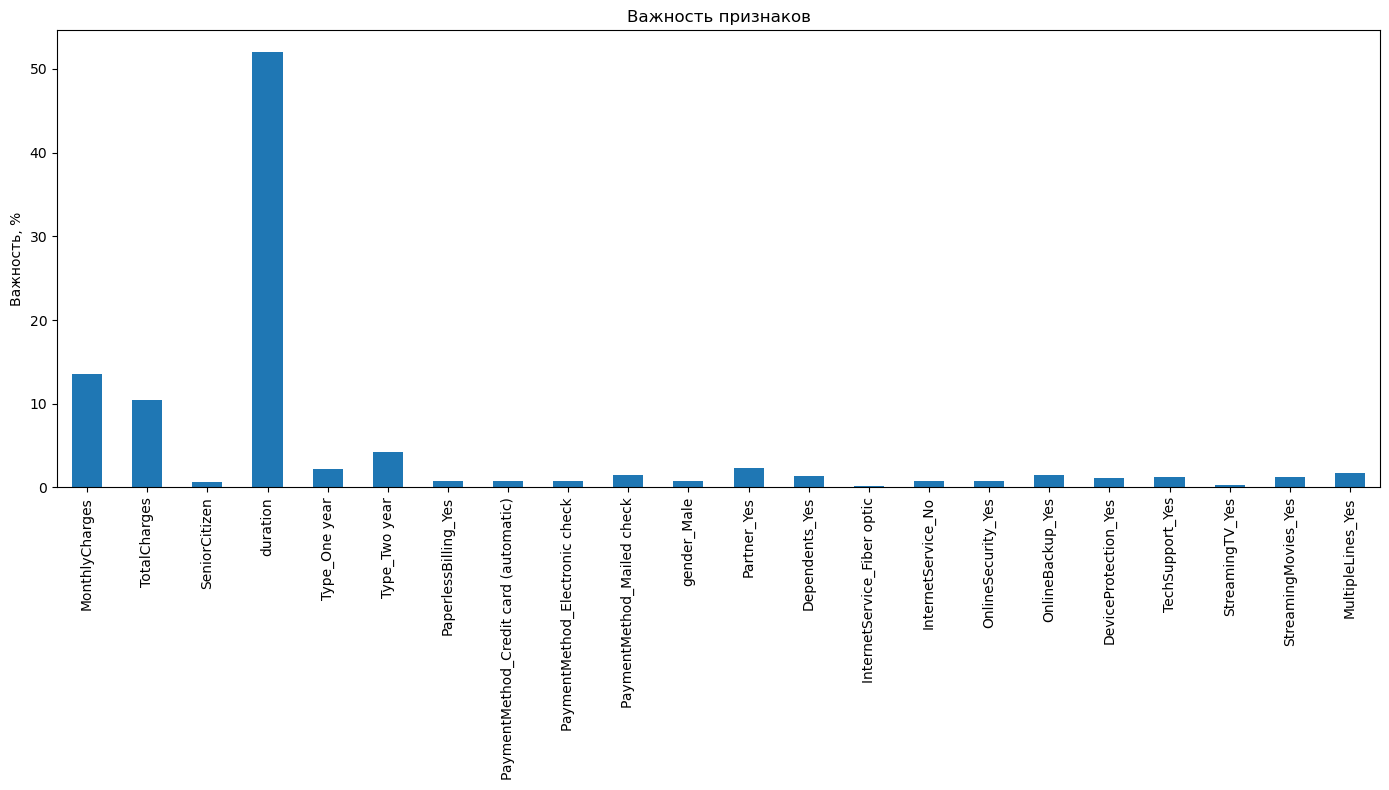

In [49]:
cat_iris_imp = pd.Series(ct_RandomGrid.best_estimator_.get_feature_importance(),
                         x_test_coded.columns)
fig, ax = plt.subplots(figsize=(14,8))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Анализ важности признаков показывает, что самых существенным признаком оказывется новосозданный длительность, так же ежемесяный платеж и, на прямую от него зависящий, сумма платежей.

### Вывод 
***
Проделав все выше описанные этапы удалось добится цели, получить модель с удовлетворяющей  метрикой.

### Выполненые пункты плана
***
- [x] Анализ данных (Аномалии не выявленны)

Данные будут исследованны на аномалии и ошибки
- [x] Подготовка признаков  

Из данных будут выделенны признаки, которые будут подготовленны для корректной работы модели и удалены признаки, которые мешают работе модели
- [x] Исследование моделей
    - Данные будут разделенны на выборки 
    - Будут обучены несколько моделей и полученные результаты на валидационой выборки 
    - Сравнение результатов моделей
- [x] Тестирование модели 

Лучшая модель будет проверенна на тестовой выборке 
- [x] Подготовка отчета 

Удалось успешно выполнить все пункты плана.

### Трудности
***

Самыми сложным этапом я могу назвать анализ корреляций. Инструментами питона не сложно создать саму матрцу, но её анализ ослажняет денежная взаимосвязь признаков возникает весомые значения корреляции(выше 0.4) которые для меня не имеют большого смысла, либо сами по себе очевидны, что ослажняет анализ.

Так же составление портрета пользователя, когда много значний тяжело выстраивать логические связи и приходится на месте выдумывать понятные способы визуализировать данные. В качестве примера могу привести зеркальную столбчатую диаграмму, которая получилось создать почти случайно, но оказалось очень локаничным решением.

